In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
#
from scipy.spatial.distance import cdist
import torch
from torch.nn import functional as F
from torch.optim import SGD, Adam

In [2]:
path_idx = '/mnt/data2t2/data/annaha/idx-okl_val0_sh.txt'
wdir = os.path.dirname(path_idx)
data_idx = pd.read_csv(path_idx)
data_idx['path_abs'] = [os.path.join(wdir, x) for x in data_idx['path']]
#
path_pkl = data_idx.iloc[0]['path_abs']

In [3]:
data_raw = pkl.load(open(path_pkl, 'rb'))
coords = data_raw['coords']
c1, c2 = coords
dst12 = cdist(c1, c2)

In [4]:
dsts = []
for xi, x in enumerate(data_idx['path_abs']):
    data_raw = pkl.load(open(x, 'rb'))
    coords = data_raw['coords']
    c1, c2 = coords
    dst_ = cdist(c1.mean(axis=0)[None, ...], c2.mean(axis=0)[None, ...])
    dsts.append(float(dst_))
    if (xi % 100) == 0:
        print('{}/{}'.format(xi, len(data_idx)))

0/2679
100/2679
200/2679
300/2679
400/2679
500/2679
600/2679
700/2679
800/2679
900/2679
1000/2679
1100/2679
1200/2679
1300/2679
1400/2679
1500/2679
1600/2679
1700/2679
1800/2679
1900/2679
2000/2679
2100/2679
2200/2679
2300/2679
2400/2679
2500/2679
2600/2679


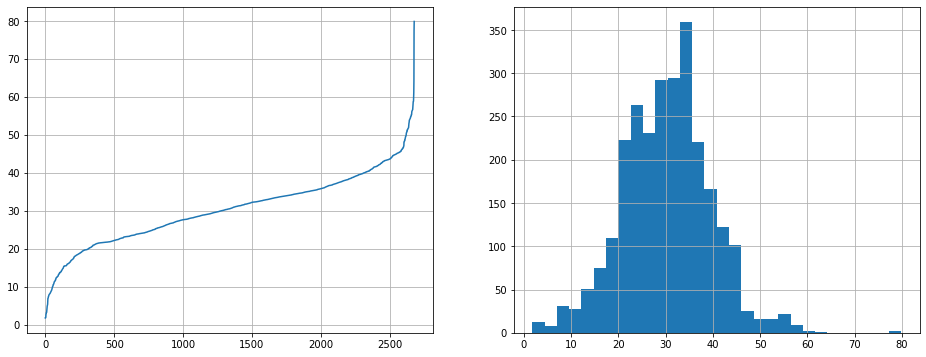

In [5]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(sorted(dsts))
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(dsts, bins=30)
plt.grid()

In [19]:
def cdist_torch(v1: torch.tensor, v2: torch.tensor, norm=2, eps=1e-5) -> torch.tensor:
    n_1, n_2 = v1.size(0), v2.size(0)
    dim = v1.size(1)
    expanded_1 = v1.unsqueeze(1).expand(n_1, n_2, dim)
    expanded_2 = v2.unsqueeze(0).expand(n_1, n_2, dim)
    differences = torch.abs(expanded_1 - expanded_2) ** norm
    inner = torch.sum(differences, dim=2, keepdim=False)
    return (eps + inner) ** (1. / norm)

def calc_loss_dst():
    loss_ = torch.mean(torch.abs( dst12 - cdist_torch(x1[:, :3], x1.mm(T.T) )))
    return loss_

def calc_loss_t(dst_t: float, dst12: torch.tensor):
    dst_t2 = dst_t * 0.5
    loss_ = torch.mean(torch.abs( dst_t2 - cdist_torch(x1[:, :3], x1.mm(T.T) )[dst12 < dst_t]   ))
    return loss_

def calc_RMSD(x1: torch.tensor, x2: torch.tensor, T: torch.tensor) -> float:
    with torch.no_grad():
        score_ = torch.sqrt( torch.mean((x2[..., :3] - x1.mm(T.T)) ** 2))
    return score_

In [24]:
to_device = 'cuda:1'
x1_npy = np.concatenate([c1, np.ones([c1.shape[0], 1])], axis=-1).astype(np.float32)
x2_npy = np.concatenate([c2, np.ones([c2.shape[0], 1])], axis=-1).astype(np.float32)
#
T_npy = np.eye(4)[:3, ...].astype(np.float32)
dst12_npy = cdist(x1_npy, x2_npy).astype(np.float32)
#
x1 = torch.tensor(x1_npy, requires_grad=False, device=to_device)
x2 = torch.tensor(x2_npy, requires_grad=False, device=to_device) #.to(to_device)
T = torch.tensor(T_npy, requires_grad=True, device=to_device) #.to(to_device)
dst12 = torch.tensor(dst12_npy, requires_grad=False, device=to_device) #.to(to_device)
#

In [25]:
optimizer = Adam([T]) #.to(to_device)

In [26]:
dst_t = 5
hist_loss, hist_RMSD = [], []
for xi in range(40000):
    optimizer.zero_grad()
    # loss = calc_loss_dst()
    loss = calc_loss_t(dst_t, dst12)
    loss.backward()
    optimizer.step()
    if (xi % 1000) == 0:
        RMSD = calc_RMSD(x1, x2, T)
        print('{} : loss ~ {:0.3f}, RMSD ~ {:0.3f}'.format(xi, float(loss), RMSD))
        hist_loss.append(float(loss))
        hist_RMSD.append(float(RMSD))

0 : loss ~ 24.214, RMSD ~ 20.224
1000 : loss ~ 5.097, RMSD ~ 9.403
2000 : loss ~ 0.696, RMSD ~ 9.133
3000 : loss ~ 0.482, RMSD ~ 8.546
4000 : loss ~ 0.451, RMSD ~ 8.310
5000 : loss ~ 0.445, RMSD ~ 8.224
6000 : loss ~ 0.443, RMSD ~ 8.189
7000 : loss ~ 0.440, RMSD ~ 8.163
8000 : loss ~ 0.437, RMSD ~ 8.136
9000 : loss ~ 0.436, RMSD ~ 8.114
10000 : loss ~ 0.436, RMSD ~ 8.091
11000 : loss ~ 0.434, RMSD ~ 8.063
12000 : loss ~ 0.437, RMSD ~ 8.042
13000 : loss ~ 0.435, RMSD ~ 8.014
14000 : loss ~ 0.433, RMSD ~ 7.996
15000 : loss ~ 0.434, RMSD ~ 7.972
16000 : loss ~ 0.431, RMSD ~ 7.957
17000 : loss ~ 0.436, RMSD ~ 7.930
18000 : loss ~ 0.430, RMSD ~ 7.914
19000 : loss ~ 0.429, RMSD ~ 7.895
20000 : loss ~ 0.429, RMSD ~ 7.876
21000 : loss ~ 0.430, RMSD ~ 7.860
22000 : loss ~ 0.431, RMSD ~ 7.846
23000 : loss ~ 0.430, RMSD ~ 7.836
24000 : loss ~ 0.434, RMSD ~ 7.830
25000 : loss ~ 0.429, RMSD ~ 7.818
26000 : loss ~ 0.428, RMSD ~ 7.811
27000 : loss ~ 0.428, RMSD ~ 7.811
28000 : loss ~ 0.428, RMSD ~ 7.

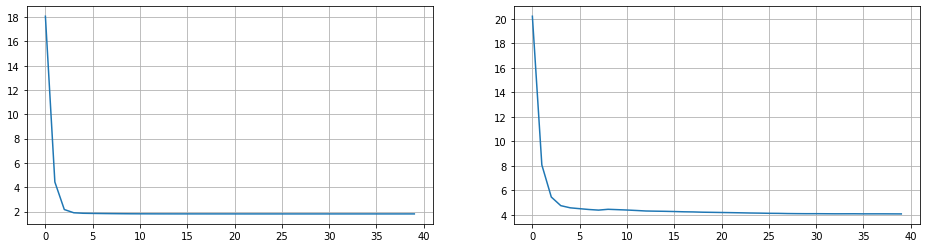

In [23]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_loss)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(hist_RMSD)
plt.grid()
